## LSTM Network predictions

In [1]:
##create the classes and prepare the data
import os, sys

sys.path.append(os.path.abspath("../data_set_generator"))
sys.path.append(os.path.abspath("../network_training"))
sys.path.append(os.path.abspath("../data_preprocessing"))
sys.path.append(os.path.abspath("../data"))


project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.insert(0, project_root)


os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0"
import keras
from keras import optimizers
from keras.models import Sequential
from data_set_generator.bike_prediction import DataGenerator
from data_set_generator.data_config import BikeDataConfig
from network_training.network_generator import NetworkGenerator
from network_training.callbacks import Callbacks

classes = 8
conf = BikeDataConfig(bikes_path = './/../data//bikes.csv', weather_path = './/../data//weather.csv', highest_class = classes)
FFN_logs_base_dir='./Modellcheckpoints/lstm/'
os.makedirs(FFN_logs_base_dir, exist_ok=True)
FFN_log_dir=os.path.join(FFN_logs_base_dir, '_LSTM.h5')
callbacks = Callbacks(filepath = FFN_log_dir)


batch_size = 256
input_dims = 11
output_dims = classes + 1 
sequence_length = 3
adam_optimizer = optimizers.Adam(learning_rate = 1e-4, beta_1=1- 1e-4, amsgrad = True)
sgd_optimizer = optimizers.SGD(learning_rate = 1e-2,  momentum = 0.9, nesterov = True)

network_gen = NetworkGenerator(data_generator = conf.d_gen, callbacks = callbacks, history_length = sequence_length)

2025-06-23 19:27:50.551626: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Create Batch Generators

In [2]:
train_data_generator = network_gen.batch_generator(batch_size = batch_size, 
                             sequence_length = network_gen.history_length, 
                             x_data = network_gen.data_gen.train_list_x,
                             y_data = network_gen.data_gen.train_list_y,
                             min_index = 0,
                             num_x_signals = input_dims,
                             num_y_signals = output_dims,
                             random = True)

val_data_generator = network_gen.batch_generator(batch_size = batch_size, 
                             sequence_length = network_gen.history_length, 
                             x_data = network_gen.data_gen.vali_list_x,
                             y_data = network_gen.data_gen.vali_list_y,
                             min_index = 0,
                             num_x_signals = input_dims,
                             num_y_signals = output_dims,
                             all_data = True)

test_data_generator = network_gen.batch_generator(batch_size = batch_size, 
                             sequence_length = network_gen.history_length, 
                             x_data = network_gen.data_gen.test_list_x,
                             y_data = network_gen.data_gen.test_list_y,
                             min_index = 0,
                             num_x_signals = input_dims,
                             num_y_signals = output_dims,
                             all_data = True)

x_batch, y_batch = next(train_data_generator)
print(x_batch)
print(y_batch)

[[[ 0.77469835  0.54316378  0.         ...  1.          0.21643961
    0.97629601]
  [ 0.77469835  0.54316378  0.         ...  1.          0.19509032
    0.98078528]
  [ 0.77469835  0.54316378  0.         ...  1.          0.17364818
    0.98480775]]

 [[ 0.77468936  0.54317987  0.         ...  1.         -0.62592347
   -0.77988448]
  [ 0.77468936  0.54317987  0.         ...  1.         -0.60876143
   -0.79335334]
  [ 0.77468936  0.54317987  0.         ...  1.         -0.59130965
   -0.8064446 ]]

 [[ 0.77468837  0.54314303  0.         ...  0.          0.64278761
   -0.76604444]
  [ 0.77468837  0.54314303  0.         ...  0.          0.65934582
   -0.75183981]
  [ 0.77468837  0.54314303  0.         ...  0.          0.67559021
   -0.73727734]]

 ...

 [[ 0.77461529  0.54307175  0.         ...  1.         -0.76604444
   -0.64278761]
  [ 0.77461529  0.54307175  0.         ...  1.         -0.75183981
   -0.65934582]
  [ 0.77461529  0.54307175  0.         ...  1.         -0.73727734
   -0.67

## Define and Generate a LSTM Network

In [3]:
lstm = Sequential()
lstm.add(keras.layers.LSTM(input_dims,
                     recurrent_dropout=0.5, 
                     return_sequences=True, 
                     input_shape = ( x_batch.shape[1], x_batch.shape[2] )  )
         )

lstm.add(keras.layers.LSTM(4*input_dims+1,
                      dropout=0.1,
                      recurrent_dropout=0.5,
                      activation = 'relu',
                      return_sequences=True)
          )

lstm.add(keras.layers.LSTM(4*input_dims+1,
                      dropout=0.1,
                      recurrent_dropout=0.5, 
                      activation = 'relu'
                      )
          )

lstm.add(keras.layers.Dense(output_dims, activation = 'softmax'))
lstm.summary()

network_gen.register_network(lstm)
network_gen.model.compile(optimizer = sgd_optimizer, loss = 'categorical_crossentropy', metrics = ['categorical_accuracy'])
results = network_gen.train_network(validation_data = val_data_generator, epochs = 25, train_data = train_data_generator)

/home/flo/python_environments/ml/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 3, 11)          │         1,012 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 3, 45)          │        10,260 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 45)             │        16,380 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 9)              │           414 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,066 (109.63 KB)

 Trainable params: 28,066 (109.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/25
1283/1283 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - categorical_accuracy: 0.1667 - loss: 2.1259

1283/1283 ━━━━━━━━━━━━━━━━━━━━ 178s 134ms/step - categorical_accuracy: 0.1667 - loss: 2.1259 - val_categorical_accuracy: 0.4139 - val_loss: 1.4198
Epoch 2/25
1283/1283 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - categorical_accuracy: 0.6719 - loss: 0.9396

1283/1283 ━━━━━━━━━━━━━━━━━━━━ 55s 43ms/step - categorical_accuracy: 0.6719 - loss: 0.9394 - val_categorical_accuracy: 0.8496 - val_loss: 0.6017
Epoch 3/25
1283/1283 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - categorical_accuracy: 0.8542 - loss: 0.5972

1283/1283 ━━━━━━━━━━━━━━━━━━━━ 55s 43ms/step - categorical_accuracy: 0.8542 - loss: 0.5972 - val_categorical_accuracy: 0.8739 - val_loss: 0.5516
Epoch 4/25
1283/1283 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - categorical_accuracy: 0.8834 - loss: 0.5087

1283/1283 ━━━━━━━━━━━━━━━━━━━━ 62s 48ms/step - categorical_accuracy: 0.8834 - loss: 0.5087 - val_categorical_accuracy: 0.8758 - val_loss: 0.5156
Epoch 5/25
1282/1283 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - categorical_accuracy: 0.8970 - loss: 0.4587

1283/1283 ━━━━━━━━━━━━━━━━━━━━ 58s 45ms/step - categorical_accuracy: 0.8970 - loss: 0.4587 - val_categorical_accuracy: 0.8793 - val_loss: 0.4980
Epoch 6/25
1283/1283 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - categorical_accuracy: 0.9030 - loss: 0.4305

1283/1283 ━━━━━━━━━━━━━━━━━━━━ 63s 49ms/step - categorical_accuracy: 0.9030 - loss: 0.4305 - val_categorical_accuracy: 0.8791 - val_loss: 0.4849
Epoch 7/25
1283/1283 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - categorical_accuracy: 0.9076 - loss: 0.4074

1283/1283 ━━━━━━━━━━━━━━━━━━━━ 60s 46ms/step - categorical_accuracy: 0.9076 - loss: 0.4074 - val_categorical_accuracy: 0.8803 - val_loss: 0.4735
Epoch 8/25
1283/1283 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - categorical_accuracy: 0.9092 - loss: 0.3950

1283/1283 ━━━━━━━━━━━━━━━━━━━━ 59s 46ms/step - categorical_accuracy: 0.9092 - loss: 0.3950 - val_categorical_accuracy: 0.8806 - val_loss: 0.4665
Epoch 9/25
1282/1283 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - categorical_accuracy: 0.9120 - loss: 0.3805

1283/1283 ━━━━━━━━━━━━━━━━━━━━ 55s 43ms/step - categorical_accuracy: 0.9120 - loss: 0.3805 - val_categorical_accuracy: 0.8804 - val_loss: 0.4649
Epoch 10/25
1283/1283 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - categorical_accuracy: 0.9127 - loss: 0.3775

1283/1283 ━━━━━━━━━━━━━━━━━━━━ 54s 42ms/step - categorical_accuracy: 0.9127 - loss: 0.3775 - val_categorical_accuracy: 0.8833 - val_loss: 0.4595
Epoch 11/25
1283/1283 ━━━━━━━━━━━━━━━━━━━━ 53s 42ms/step - categorical_accuracy: 0.9142 - loss: 0.3709 - val_categorical_accuracy: 0.8825 - val_loss: 0.4613
Epoch 12/25
1283/1283 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - categorical_accuracy: 0.9155 - loss: 0.3650

1283/1283 ━━━━━━━━━━━━━━━━━━━━ 56s 43ms/step - categorical_accuracy: 0.9155 - loss: 0.3650 - val_categorical_accuracy: 0.8837 - val_loss: 0.4566
Epoch 13/25
1283/1283 ━━━━━━━━━━━━━━━━━━━━ 58s 46ms/step - categorical_accuracy: 0.9157 - loss: 0.3654 - val_categorical_accuracy: 0.8814 - val_loss: 0.4587
Epoch 14/25
1283/1283 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - categorical_accuracy: 0.9167 - loss: 0.3610

1283/1283 ━━━━━━━━━━━━━━━━━━━━ 62s 48ms/step - categorical_accuracy: 0.9167 - loss: 0.3610 - val_categorical_accuracy: 0.8831 - val_loss: 0.4525
Epoch 15/25
1283/1283 ━━━━━━━━━━━━━━━━━━━━ 63s 49ms/step - categorical_accuracy: 0.9178 - loss: 0.3565 - val_categorical_accuracy: 0.8830 - val_loss: 0.4590
Epoch 16/25
1283/1283 ━━━━━━━━━━━━━━━━━━━━ 64s 50ms/step - categorical_accuracy: 0.9179 - loss: 0.3566 - val_categorical_accuracy: 0.8826 - val_loss: 0.4541
Epoch 17/25
1283/1283 ━━━━━━━━━━━━━━━━━━━━ 61s 47ms/step - categorical_accuracy: 0.9180 - loss: 0.3561 - val_categorical_accuracy: 0.8835 - val_loss: 0.4572
Epoch 18/25
1283/1283 ━━━━━━━━━━━━━━━━━━━━ 59s 46ms/step - categorical_accuracy: 0.9187 - loss: 0.3530 - val_categorical_accuracy: 0.8831 - val_loss: 0.4550
Epoch 19/25
1283/1283 ━━━━━━━━━━━━━━━━━━━━ 63s 49ms/step - categorical_accuracy: 0.9193 - loss: 0.3523 - val_categorical_accuracy: 0.8836 - val_loss: 0.4537
Epoch 20/25
1283/1283 ━━━━━━━━━━━━━━━━━━━━ 62s 48ms/step - categorical

1283/1283 ━━━━━━━━━━━━━━━━━━━━ 57s 44ms/step - categorical_accuracy: 0.9189 - loss: 0.3517 - val_categorical_accuracy: 0.8853 - val_loss: 0.4516
Epoch 22/25
1282/1283 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - categorical_accuracy: 0.9199 - loss: 0.3476

1283/1283 ━━━━━━━━━━━━━━━━━━━━ 59s 46ms/step - categorical_accuracy: 0.9199 - loss: 0.3476 - val_categorical_accuracy: 0.8840 - val_loss: 0.4507
Epoch 23/25
1283/1283 ━━━━━━━━━━━━━━━━━━━━ 51s 40ms/step - categorical_accuracy: 0.9201 - loss: 0.3478 - val_categorical_accuracy: 0.8844 - val_loss: 0.4531
Epoch 24/25
1283/1283 ━━━━━━━━━━━━━━━━━━━━ 52s 40ms/step - categorical_accuracy: 0.9202 - loss: 0.3464 - val_categorical_accuracy: 0.8843 - val_loss: 0.4512
Epoch 25/25
1283/1283 ━━━━━━━━━━━━━━━━━━━━ 55s 43ms/step - categorical_accuracy: 0.9202 - loss: 0.3457 - val_categorical_accuracy: 0.8839 - val_loss: 0.4533


## Print Training Results

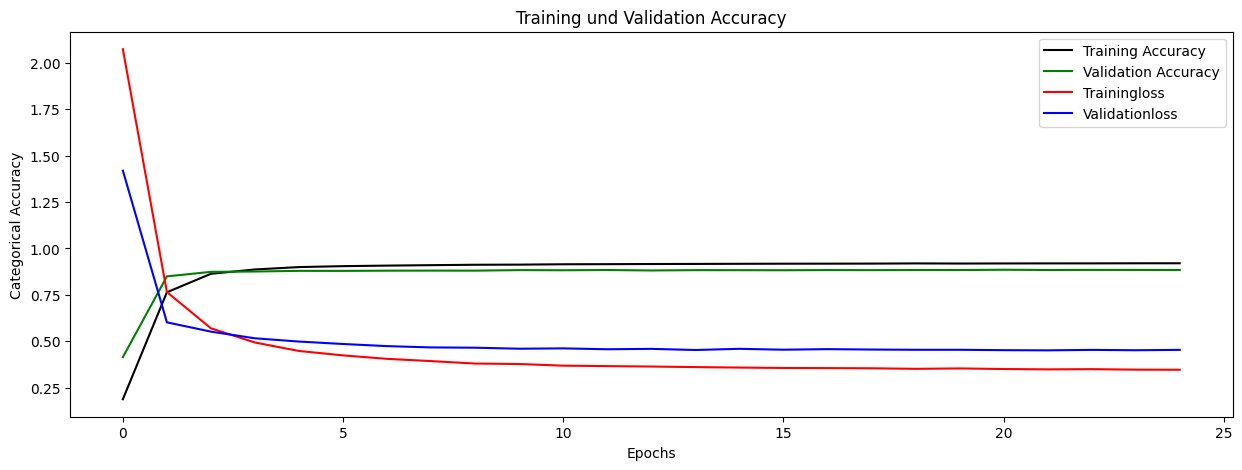

In [4]:
network_gen.print_training(results)

## Test Network and Create Metrics

In [5]:
x_batch, y_batch = next(test_data_generator)
network_gen.test_predictions(network_gen.model, x_batch, y_batch, True)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 3, 11)          │         1,012 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 3, 45)          │        10,260 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 45)             │        16,380 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 9)              │           414 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 56,134 (219.28 KB)

 Trainable params: 28,066 (109.63 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 28,068 (109.64 KB)

17595/17595 ━━━━━━━━━━━━━━━━━━━━ 47s 3ms/step - categorical_accuracy: 0.8971 - loss: 0.4170
17595/17595 ━━━━━━━━━━━━━━━━━━━━ 45s 3ms/step
Confusion Matrix
[[ 84072   3607    507    113     26     10      4      1      3]
 [  3651  67943   3479    554     96     22     10      2      0]
 [   427   3396  55509   3315    492     78     21      6      4]
 [   105    490   3153  47188   2754    467    105     39     32]
 [    56    101    367   2643  39337   2651    414     88     81]
 [    18     52     84    380   2523  30022   3408    398    159]
 [    28     33     56    110    374   2256  25518   2015    535]
 [     6      9     18     31     66    300   2137  24503   2212]
 [    37     50     29     39     41     99    469   2299 135284]]
Klassifikations Report
0.9047257898074126
Akkuratheit der Klassifikation
              precision    recall  f1-score   support

           0       0.95      0.95      0.95     88343
           1       0.90      0.90      0.90     75757
           2  